In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from utils import generate_data
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
plt.rcParams["figure.figsize"] = (12,6)
import warnings
from timeit import default_timer as timer

/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = generate_data()

In [3]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [4]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 6.021999
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 7


In [5]:
gpois_res.params

intercept                   5.246028
days_since_start            0.338119
days_since_start_squared   -0.117401
day_of_week_1               0.225497
day_of_week_2               0.241959
day_of_week_3               0.349975
day_of_week_4               0.293703
day_of_week_5               0.170436
day_of_week_6               0.046007
seasonality_cos             0.147884
seasonality_sin            -0.040537
alpha                       6.973372
dtype: float64

In [6]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.050      
Dependent Variable:    y                   AIC:               13212.1788 
Date:                  2022-04-04 14:11    BIC:               13272.1609 
No. Observations:      1095                Log-Likelihood:    -6594.1    
Df Model:              10                  LL-Null:           -6941.1    
Df Residuals:          1084                LLR p-value:       1.2666e-142
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2460   0.0383 137.1504 0.0000  5.1711  5.3210
days_since_start          0.3381   0.0145  23.2727 0.0000  0.3096  0.3666
days_since_start_squared -0.1174   0.0136  -8.6615 0.0000 -0.

In [7]:
# Marginal effects
me = gpois_res.get_margeff(method='dydx')
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 GeneralizedPoisson Marginal Effects 
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
days_since_start            83.3282      3.802     21.916      0.000      75.876      90.780
days_since_start_squared   -28.9332      3.370     -8.586      0.000     -35.538     -22.328
day_of_week_1               55.5729     12.437      4.468      0.000      31.197      79.949
day_of_week_2               59.6300     12.444      4.792      0.000      35.240      84.020
day_of_week_3               86.2502     12.268      7.030      0.000      62.205     110.296
day_of_week_4               72.3822     12.348      5.862      0.000      48.181      96.583
day_of_week_5               42.0034     12.553      3.346      0.001      17.400      66.607
day_of_week_6               11.3382     12.758      0.889      0.374     -13.667      36.343
seasonality_cos             36.4455      4.650      7.837      0.000      27.331      45.560
seasonality_sin             -9.9901      4.725     -2.114      0.034     -19.251      -0.729
============================================================================================
"""

## Extend Generic Likelihood Model

In [8]:
eps = 0. #to fix log(0) error
def _ll_latentnorm(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))
    Phi_bar = stats.norm(mu, sigma).cdf(np.log1p(y))
    Phi_underbar = stats.norm(mu, sigma).cdf(np.log(y))
    ll = np.log(Phi_bar - Phi_underbar + eps)
    #print(Phi_bar - Phi_underbar)
    return ll

def _gradutils(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))

    z_bar = (np.log1p(y) - mu) / sigma 
    z_underbar = (np.log(y) - mu) / sigma

    Phi_bar = stats.norm.cdf(z_bar)
    Phi_underbar = stats.norm.cdf(z_underbar)
    Phi  = Phi_bar - Phi_underbar + eps #small tolerance to fix div/zero error

    phi_bar = stats.norm.pdf(z_bar)
    phi_underbar = stats.norm.pdf(z_underbar)
    phi = phi_bar - phi_underbar + eps #small tolerance
    
    kappa_0 = phi / Phi
    kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
    kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / Phi
    kappa_3 = (z_bar**3 * phi_bar - z_underbar**3 * phi_underbar) / Phi
    
    return kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma
    
def _vec_matrix_multiply(a, B):
    return np.apply_along_axis(lambda x: x * a, 0, B)

def _em_gradutils(W, sigma, c, alpha, return_hessian=False):
    sigma_neg_2 = sigma**-2
    grad = W.T @ (sigma_neg_2 * c - 1.) - alpha
    hessian = None
    if return_hessian:
        W_sqrt_k = _vec_matrix_multiply(np.sqrt(c)/sigma, W)
        hessian = -2. * W_sqrt_k.T @ W_sqrt_k
    return grad, hessian

In [9]:
class MyLatentNormal(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyLatentNormal, self).__init__(endog, exog, **kwds)
        self.nparams = 22
        
    def nloglikeobs(self, params):
        exog = self.exog
        endog = self.endog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        ll = _ll_latentnorm(endog, exog, beta, alph)
        params_alt = params.copy()
        params_alt[0] = 0.
#         params_alt[11] = 0.
        return -ll - self.penalty*np.sum(params_alt**2)/self.endog.size
    
    def score(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        beta_alt = beta.copy()
        beta_alt[0] = 0
        alph_alt = alph.copy()
#         alph_alt[0] = 0.
        
        grad_beta = -(kappa_0 / sigma) @ X - self.penalty*2 * beta_alt
        grad_alph = -kappa_1 @ X - self.penalty*2 * alph_alt
        
        return np.append(grad_beta, grad_alph)
    
    def hessian(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        #xx = np.einsum('ij,ij-> i', X, X) # row-wise dot product?
        k_beta = (kappa_0**2 + kappa_1) / sigma**2
        k_alph = kappa_1 * (kappa_1 - 1) + kappa_3
        k_beta_alph = (kappa_2 + kappa_0*(kappa_1 - 1)) / sigma
        H_beta = np.zeros([11, 11])
        H_alph = np.zeros([11, 11])
        H_beta_alph = np.zeros([11, 11])
                  
        for i in range(X.shape[0]):
            x = X[i]
            xxT = np.outer(x, x)
            H_beta -= k_beta[i] * xxT
            H_alph -= k_alph[i] * xxT
            H_beta_alph -= k_beta_alph[i] * xxT
        
        H_all = np.block([[H_beta, H_beta_alph], [H_beta_alph.T, H_alph]]) # 22 x 22
        penalty_matrix = self.penalty*2 * np.eye(22)
        penalty_matrix[0, 0] = 0.
#         penalty_matrix[11, 11] = 0.

        return H_all - penalty_matrix
    
    def predict(self, params, exog=None, n=1000):
        if exog is None:
            X = self.exog
        else:
            X = exog
            
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        mu = (np.dot(X, beta))
        sigma = np.exp(np.dot(X, alph))
        Z = stats.norm(mu,sigma).rvs(size = (n, self.endog.size)) # n random realizations. Could find closed form..
        Y_hat = np.floor(np.exp(Z)).mean(axis=0)
        return Y_hat
    
    def mse(self):
        r = self.endog - self.predict()
        return np.mean(r**2)
    
    
    def fit(self, start_params=None, method="EM", maxiter=100, use_hessian=False, step_size=1e-4, tol=1e-6, maxfun=5000, penalty=0., **kwds):
        self.penalty = penalty
        if start_params is None:
            # Reasonable starting values
            start_params = np.zeros(self.nparams)
            start_params[0] = np.log(np.mean(self.endog)) # beta intercept

        if method == "EM":  
            print("Using EM algorithm")
            self.em(
                start_params=start_params,
                maxiter=maxiter,
                use_hessian=use_hessian,
                step_size=step_size,
                tol=tol)
            return self

        else:
            return super(MyLatentNormal, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun, method=method,
                                     **kwds)


    def update_beta(self, beta):
        self.beta = beta
        self.mu = self.exog @ beta
        
        
    def update_alpha(self, alpha):
        self.alpha = alpha
        self.sigma = np.exp(self.exog @ alpha)
    
    
    def update_expectations(self):
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(self.endog, self.exog, self.beta, self.alpha)
        self.e1 = self.mu - self.sigma * kappa_0
        sigma2 = self.sigma**2
        self.e2 = (
            sigma2 -
            sigma2 * kappa_1 +
            self.mu**2 -
            2*self.mu*self.sigma*kappa_0
        )
        

    def em(self, start_params, maxiter, use_hessian=False, step_size=1e-4, tol=1e-4):
        # Starting values
        loss = self.nloglikeobs(start_params).mean()
        self.update_beta(start_params[:11])
        self.update_alpha(start_params[11:])
        X = self.exog
        W = self.exog
        penalty_alpha = self.penalty * np.eye(11)
        WtW_plus_penalty = W.T @ W + penalty_alpha
        penalty_beta = penalty_alpha.copy()
        penalty_beta[0] = 0.
        converged = False
        
        for i in range(maxiter):
            print(f"Iteration {i} loss: {loss}")
            loss_last = loss.copy()
            self.update_expectations()
                                    
            # Calculate beta
            X_sqrt_w = _vec_matrix_multiply(1./self.sigma, X)
            XtSiX = X_sqrt_w.T @ X_sqrt_w
            XtSiX += penalty_beta
            XtSie1 = X.T @ (self.sigma**-2 * self.e1)
            beta = np.linalg.solve(XtSiX, XtSie1)
            
            # Calculate alpha
            c = self.e2 - 2*self.e1*self.mu + self.mu**2 # NOTE: This is using the updated mu
            if use_hessian:
                grad, hessian = _em_gradutils(W, self.sigma, c, self.alpha, return_hessian=True)
                grad -= self.alpha
                hessian -= penalty_alpha
                alpha = self.alpha - np.linalg.solve(hessian, grad)
            else:
                # Backtracking line search
                grad, _ = _em_gradutils(W, self.sigma, c, self.alpha)
                d = -grad # Descent direction
                prop_increase = 0.5 # Called alpha in notes
                step_multiplier = 0.5 # Called beta in notes
                curr_step_size = step_size # Called eta in notes
                f_start = self.nloglikeobs(np.concatenate([self.beta, self.alpha])).sum()
                while True:
                    alpha = self.alpha - curr_step_size * d
                    f_stop = self.nloglikeobs(np.concatenate([self.beta, alpha])).sum()
                    required_change = prop_increase * curr_step_size * (grad @ d)
                    if f_stop - f_start <= required_change:
                        break
                    curr_step_size *= step_multiplier
            
            # Update alpha, beta simultaneously
            self.update_alpha(alpha)
            self.update_beta(beta)

            # Check convergence
            params = np.concatenate([self.beta, self.alpha])
            loss = self.nloglikeobs(params).mean()
            obj = loss_last - loss # Want this to be positive
            if abs(obj) < tol: # Not enforcing any sort of sign constraint for now
                converged = True
                break
        else:
            raise RuntimeError("Hit maxiter and failed to converge")
            
        self.params = np.concatenate([self.beta, self.alpha])
        self.iters = i
        self.loss = loss
        self.loss_last = loss_last
        self.obj = obj
        self.converged = converged
    

def fittedmean(res):
    return pd.Series(res.exog @ res.params[:11])

def fittedvar(res):
    return pd.Series(np.exp(res.exog @ res.params[11:]))

def mse(yhat, y):
    r = y - yhat
    return np.mean(r**2)

In [10]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [11]:
# np.seterr(divide = 'warn')
# np.seterr(invalid= 'warn')

start_params = 0. * np.ones(22)
start_params[:11] = gpois_res.params[:11]
start_params[11] = -1.
mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)

mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=1e-4)
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

Optimization terminated successfully.
         Current function value: 5.937358
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 10
                            MyLatentNormal Results                            
Dep. Variable:                      y   Log-Likelihood:                -6501.4
Model:                 MyLatentNormal   AIC:                         1.302e+04
Method:            Maximum Likelihood   BIC:                         1.308e+04
Date:                Mon, 04 Apr 2022                                         
Time:                        14:11:10                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.0

In [12]:
# Test first-order EM
mod_em_first = mod.fit(
    start_params=start_params,
    method="EM", 
    use_hessian=False,
    maxiter=1000,
    step_size=1e-3,
    tol=1e-6,
    penalty=1.)

Using EM algorithm
Iteration 0 loss: 6.236819250553997
Iteration 1 loss: 5.986634164666055
Iteration 2 loss: 5.960025513821513
Iteration 3 loss: 5.952083754321216
Iteration 4 loss: 5.948133755252193
Iteration 5 loss: 5.947016008640128
Iteration 6 loss: 5.945682163405492
Iteration 7 loss: 5.944823778536714
Iteration 8 loss: 5.944183593653659
Iteration 9 loss: 5.943753175983754
Iteration 10 loss: 5.943218887966604
Iteration 11 loss: 5.942790533784729
Iteration 12 loss: 5.942382610245369
Iteration 13 loss: 5.942092890314943
Iteration 14 loss: 5.941693703898335
Iteration 15 loss: 5.941353834436548
Iteration 16 loss: 5.94101299845168
Iteration 17 loss: 5.940795144367074
Iteration 18 loss: 5.9404646112928505
Iteration 19 loss: 5.940179248882786
Iteration 20 loss: 5.9398894136018505
Iteration 21 loss: 5.9397222662915015
Iteration 22 loss: 5.939447409023318
Iteration 23 loss: 5.939208110885788
Iteration 24 loss: 5.938963843768123
Iteration 25 loss: 5.938788880941358
Iteration 26 loss: 5.938606

In [13]:
# Test second-order EM
mod_em_second = mod.fit(
    start_params=start_params,
    method="EM",
    use_hessian=True,
    maxiter=100,
    tol=1e-6,
    penalty=1.)
# Very sensitive to good starting values

Using EM algorithm
Iteration 0 loss: 6.236819250553997
Iteration 1 loss: 5.962934917139612
Iteration 2 loss: 5.9358627363697956
Iteration 3 loss: 5.9349364803617775
Iteration 4 loss: 5.934854954626493
Iteration 5 loss: 5.934857138493018
Iteration 6 loss: 5.934854861491275


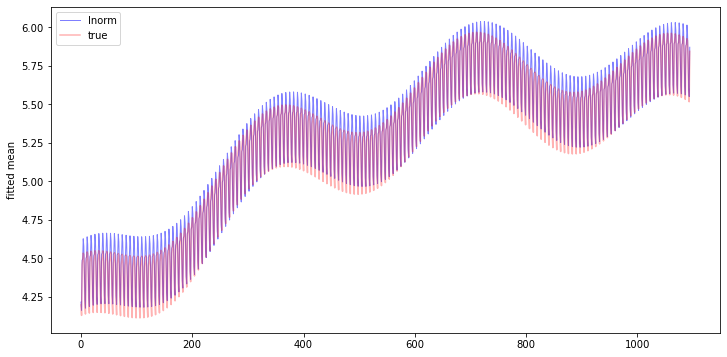

In [14]:
fittedmean(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

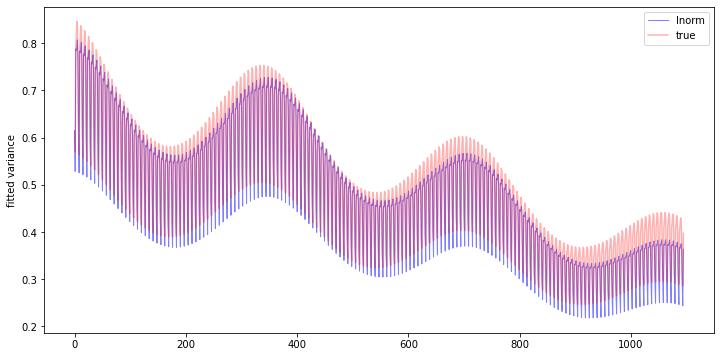

In [15]:
fittedvar(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.sigma, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted variance")
plt.show()

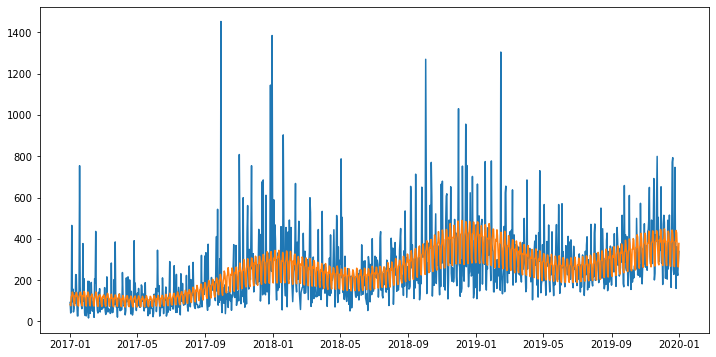

In [16]:
Y_hat = mod_res.predict(n=1000)
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

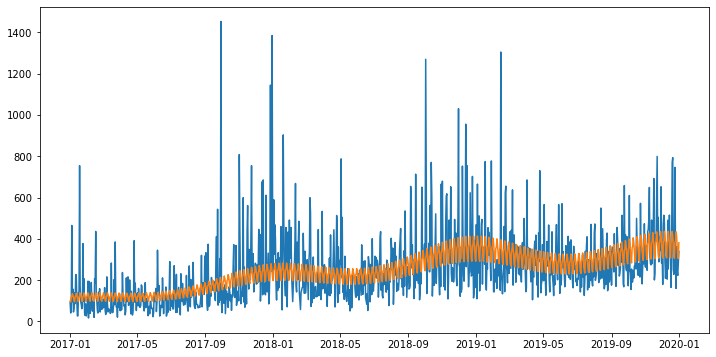

In [17]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

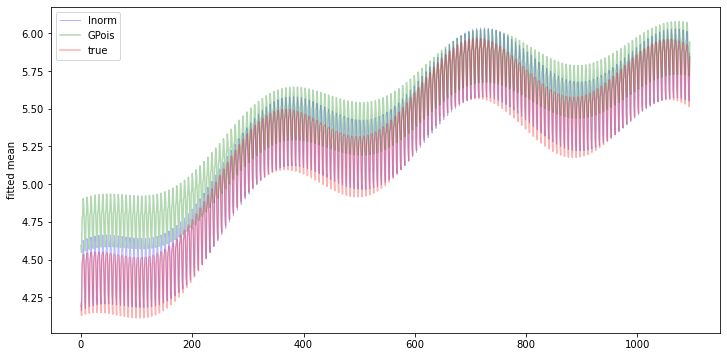

In [18]:
fittedmean(mod_res).plot(alpha = 0.3, color = "blue", linewidth = 1, label = "lnorm")
gpois_res.fittedvalues.plot(alpha = 0.3, color = "green", label = "GPois")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

In [19]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

array([1298.99416453, 1201.6775589 , 1131.00622632,  826.30974615,
        622.74188352,  540.47528949,  487.99661008,  322.83634121,
          7.31766471,   21.49242963,  252.02851454,  228.96861897,
         57.64541695,   80.45564664,   94.33910801,   89.14947212,
         85.24766856,  167.17903559,  148.46976072,  154.20644896,
        158.40363756,  157.92495064])

In [20]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     bs = mod_res.bootstrap(nrep=1, method="ncg", store = 0, disp = 0) # we can bootstrap SE

In [21]:
# bs[0] #mean estimates

## Simulation 

In [22]:
# What else should we test?
N = 50
penalty = 1e-4
sim_params = list()
sim_mse = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        sim_params.append(["pois"] + pois_res.params[:11].tolist())
        
        gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
        gpois_res = gpois_mdl.fit(disp=0)
        sim_params.append(["gpois"]+ gpois_res.params[:11].tolist())
        
        NB1_mdl = sm.NegativeBinomialP(data.y, data.x_df,p=1)
        NB1_res = NB1_mdl.fit(disp=0)
        sim_params.append(["NB1"]+ NB1_res.params[:11].tolist())
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        sim_params.append(["lnorm"] + mod_res.params[:11].tolist()) # Just the model coeffecients

        data = generate_data() #new data
        Xnew = data.x_df
        # out of sample prediction MSE
        sim_mse.append([mse(mod_res.predict(exog=Xnew), data.y), mse(pois_res.predict(exog=Xnew), data.y), 
                        mse(gpois_res.predict(exog=Xnew), data.y), mse(NB1_res.predict(exog=Xnew), data.y)])


In [23]:
sim_params = pd.DataFrame(sim_params, columns=["model"] + data.x_df.columns.to_list())

In [24]:
sim_params.groupby(by = "model").mean().T

model,NB1,gpois,lnorm,pois
intercept,5.176428,5.221445,4.997832,5.073580
days_since_start,0.344381,0.352948,0.400615,0.348321
days_since_start_squared,-0.140012,-0.130204,-0.168433,-0.169658
day_of_week_1,0.280866,0.232663,0.323958,0.380267
day_of_week_2,0.323912,0.265588,0.365562,0.442070
day_of_week_3,0.360067,0.292305,0.408695,0.494484
day_of_week_4,0.350482,0.288391,0.394543,0.476219
day_of_week_5,0.234087,0.195148,0.264527,0.315258
day_of_week_6,0.066044,0.055706,0.076833,0.088986
seasonality_cos,0.177533,0.145895,0.198287,0.238398


In [25]:
#MSE
pd.DataFrame(sim_mse, columns=["lnorm", "pois", "gpois", "NB1"]).describe()

,lnorm,pois,gpois,NB1
count,50.000000,50.000000,50.000000,50.000000
mean,20090.853428,20119.067490,20655.994642,20307.581850
std,2433.684019,2462.400636,2710.700494,2624.022783
min,16313.668446,16189.832091,16561.265027,16293.105584
25%,18458.271992,18671.801482,18700.595361,18506.338786
50%,19976.937910,20033.042793,20376.855789,20092.350684
75%,21376.734198,21430.220264,22051.514797,21656.203585
max,28263.348587,28275.765919,30118.691558,29349.078911


In [26]:
N = 50
sim_solver_times = list()
sim_solver_fcalls = list()
penalty = 1e-4

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        fcalls = []
        
        # Seed with poisson parameters
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        
        start = timer()
        mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        ncg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "cg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        cg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        bfgs = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "powell", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        powell = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        sim_solver_times.append([ncg, cg, bfgs, powell])
        sim_solver_fcalls.append(fcalls)

In [27]:
pd.DataFrame(sim_solver_times, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,0.157262,0.211196,0.052342,1.107275
std,0.010100,0.021722,0.001157,0.066766
min,0.141975,0.161151,0.049234,1.064415
25%,0.150002,0.196771,0.051603,1.079308
50%,0.157932,0.207398,0.052488,1.086831
75%,0.160558,0.225181,0.053074,1.093652
max,0.194947,0.252578,0.055025,1.312714


In [28]:
pd.DataFrame(sim_solver_fcalls, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,15.880000,131.480000,26.640000,1171.560000
std,3.668064,14.566162,0.631163,71.218881
min,13.000000,93.000000,25.000000,1139.000000
25%,14.000000,122.250000,26.000000,1146.000000
50%,15.000000,129.500000,27.000000,1148.000000
75%,16.000000,140.500000,27.000000,1152.000000
max,39.000000,159.000000,28.000000,1393.000000
